# **Global Land Cover Assessment**
<span style = "font-size: 1.5em;"> ***Global ESA WorldCover 2021 10m v200*** </span>

## Brief Description

### <span style = "font-size: 1em;"> ***Brief Description of The Asssessment*** </span>

The European Space Agency (ESA) WorldCover 10 m 2020 product provides a global land cover map for 2020 at 10 m resolution based on Sentinel-1 and Sentinel-2 data. The WorldCover product comes with 11 land cover classes and has been generated in the framework of the ESA WorldCover project, part of the 5th Earth Observation Envelope Programme (EOEP-5) of the European Space Agency. 

<span style="font-size:1.1em;"> ***Input Data Needed*** </span>
- Shapefile
> - **roi_directory** : specify region of interest shapefiile

- Input Data Variables
> - **projectname (string)** : project name (example: "RVL_IDN_KubuRaya")
> - **projection**: UTM projection code in code (example: "EPSG:3857")
> - **roi_column_name** : variable name that specifiy unique ID for multipolygon analysis (example: "Name")

- Output directory folder
> - **output_directory** : select directory folder to put the output result

<span style="font-size:1.1em;"> ***Expected Output*** </span>
- Raster dataset
> - ESA Land Cover in RoI

- csv, graph and maps 
> - ESA Land Cover Area (Ha)

### <span style = "font-size: 1em;"> ***Brief Description of The Dataset*** </span>

The European Space Agency (ESA) WorldCover 10 m 2021 product provides a global land cover map for 2021 at 10 m resolution based on Sentinel-1 and Sentinel-2 data. The WorldCover product comes with 11 land cover classes, aligned with UN-FAO's Land Cover Classification System, and has been generated in the framework of the ESA WorldCover project.

The ESA WorldCover 10m 2021 v200 product updates the existing ESA WorldCover 10m 2020 v100 product to 2021 but is produced using an improved algorithm version (v200) compared to the 2020 map. Consequently, since the WorldCover maps for 2020 and 2021 were generated with different algorithm versions (v100 and v200, respectively), changes between the maps should be treated with caution, as they include both real changes in land cover and changes due to the algorithms used.

<span style="font-size:1.1em;"> ***Source*** </span>
- ESA WorldCover 10 m 2021 v20ESA WorldCover 10 m 2021 v200
Zanaga, D., Van De Kerchove, R., Daems, D., De Keersmaecker, W., Brockmann, C., Kirches, G., Wevers, J., Cartus, O., Santoro, M., Fritz, S., Lesiv, M., Herold, M., Tsendbazar, N.E., Xu, P., Ramoino, F., Arino, O., 2022. ESA WorldCover 10 m 2021 v200. https://doi.org/10.5281/zenodo.7254221


### <span style = "font-size: 1em;"> ***Note*** </span>

- ESA new datasets v200 is using an improved algorithm compared to 2020 map
- The script will only estimate the **manngrove extent area in 2021**
- Data is extracted from ESA database https://esa-worldcover.org/en/data-access

## Data Preparation

### Import modules and Relevant Datasets

In [1]:
%matplotlib inline
import os
import geopandas as gpd
import pandas as pd
from tkinter import Tk, filedialog, simpledialog, messagebox
from tkinter import * 
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from matplotlib import colors
import geoplot as gplt
import contextily as ctx
import plotly.express as px
import numpy as np
import geoplot.crs as gcrs
import mapclassify as mc
import cartopy.io.img_tiles as cimgt
import shapely.wkt

# earth engine package
import geemap
import ee

#raster
import rasterio
from rasterio.plot import show
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
import matplotlib.patches as mpatches

In [2]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [3]:
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
roi_directory = filedialog.askopenfile(title = "Open RoI Shapefile") 
# Output folder
output_directory = filedialog.askdirectory(title = "Specify Output Folder")

In [4]:
# output directory
out_dir = os.path.expanduser(output_directory+'/RapidScreening_ESALandCoverAssessment')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Specify Input Data

In [5]:
# specify project name
projectname = simpledialog.askstring("Input", "Speficy project name",parent=root)

if projectname is not None:
    print("The script will assess ", projectname)
else:
    print("Name has not been submitted, Restart the code!")
    
#Specify Projection
projection = simpledialog.askstring("Input", "Specify Projection in UTM zone, example EPSG:3857", parent=root)

if projection is not None:
    print("All data will be reprojected to ", projection, ' canopy cover')
else:
    print("Projection has not specified, Restart the code!")
    
# column name for roi id
roi_column_name = simpledialog.askstring("Input", "Specify columns name in ROI attribute table to define boundary name",parent=root)

if roi_column_name is not None:
    print("Column name is ", roi_column_name)
else:
    print("Column has not identified, Restart the code!")

The script will assess  Katingan RoI
All data will be reprojected to  EPSG:32749  canopy cover
Column name is  NAME


In [6]:
# tile scale to avoid memory ran out issue
tileScale = 4

## Spatial Distribution of ESA Land Cover Extent

In [7]:
# roi shapefile
roi = gpd.read_file(roi_directory.name)
# roi in UTM projection
roi_proj = roi.to_crs (crs = projection)

# Convert to ee.FeatureCollection for calculation process
roi_proj_gee = geemap.geopandas_to_ee(roi_proj, geodesic=False)

In [8]:
# Import Hansen image dataset
ESA_LC_10m_2021 = ee.ImageCollection("ESA/WorldCover/v200")

# Select band called map
ESA_LC_10m_2021_map = ESA_LC_10m_2021.select('Map').first()

In [9]:
# Reproject ESA to UTMM
ESA_LC_10m_2021_map_proj = ESA_LC_10m_2021_map.reproject(crs = projection, scale = 10)

# clipped by roi
ESA_LC_10m_2021_map_roi_proj = ESA_LC_10m_2021_map_proj.clip(roi_proj_gee)

In [10]:
# visualisation parameter ESA land cover
vis_esaLC_10m = {'min': 10, 'max':100, 'palette': ['#006400', '#ffbb22', '#ffff4c', '#f096ff', '#fa0000',
                                                   '#b4b4b4', '#f0f0f0','#0064c8','#0096a0', '#00cf75', '#fae6a0']}

# roi visualisation parameter
vis_roi = {'color': '#FF0000', 'width': 2,'lineType': 'solid','fillColor': '00000000'}

### Interactive Map visualization

In [11]:
Map = geemap.Map()
Map.centerObject (roi_proj_gee, 10)

Map.addLayer(roi_proj_gee.style(**vis_roi), {}, "Region of Interest");
Map.addLayer(ESA_LC_10m_2021_map_roi_proj, vis_esaLC_10m, "RoI - ESA Land Cover 10m 2021", True)
Map.add_legend(title="ESA Land Cover 2021", builtin_legend='ESA_WorldCover', position='bottomleft')

Map

Map(center=[-2.268347429685545, 112.20939547696753], controls=(WidgetControl(options=['position', 'transparent…

### Export Results

In [12]:
# directory file for exporting zonal statistic geemap
ESALC_2021_roi_dir = os.path.join(out_dir, projectname + '_ESALandCover_2021_roi.csv')

In [13]:
# 1. ESA World Cover in 2021
geemap.zonal_statistics_by_group(
    ESA_LC_10m_2021_map_roi_proj,
    roi_proj_gee,
    ESALC_2021_roi_dir,
    statistics_type='SUM',
    denominator=10000,
    decimal_places=2,
    tile_scale = tileScale,
    scale = 10,
    crs = projection,
)

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to C:\Users\FadliUwaisElqorni\OneDrive - SYSTEMIQ Ltd\Documents\Temporary\Revalue\Rapid Assessment Script\Comparison area calculation\RapidScreening_ESALandCoverAssessment\Katingan RoI_ESALandCover_2021_roi.csv


In [14]:
geemap.ee_export_image_to_drive(
    ESA_LC_10m_2021_map_roi_proj,
    description = projectname + '_ESALandCover_2021_roi',
    folder = projectname + '_ESALC2021_Assessment',
    fileNamePrefix = projectname + '_ESALandCover_2021_roi',
    scale = 10,
    crs = projection,
    maxPixels= 1e12,
    region = roi_proj_gee.geometry()
)

## Data Visualisation

### ESA Land Cover Area Chart

In [15]:
# 1. Above Ground Biomass in RoI and Forest Extent 2022
# 1.1 RoI
ESALC_roi_table = pd.read_csv(ESALC_2021_roi_dir.replace(os.sep,'/'))

In [16]:
# renaming column names by LC class
ESALC_roi_table = ESALC_roi_table.rename({"Class_10" : "Trees",
                                          "Class_20" : "Shrubland",
                                          "Class_30" : "Grassland",
                                          "Class_40" : "Cropland",
                                          "Class_50" : "Built-up",
                                          "Class_60" : "Barren / sparse vegetation",
                                          "Class_70" : "Snow and ice",
                                          "Class_80" : "Open water",
                                          "Class_90" : "Herbaceous wetland",
                                          "Class_95" : "Mangroves",
                                          "Class_100" : "Moss and lichen",
                                          "Class_sum" : "Total Area Ha"}, axis='columns')

In [22]:
column_list

Index(['Barren / sparse vegetation', 'Built-up', 'Cropland', 'Grassland',
       'Shrubland', 'Trees', 'Total Area Ha', 'Herbaceous wetland',
       'Open water', 'system:index', 'ID', 'NAME'],
      dtype='object')

In [23]:
column_list = ESALC_roi_table.columns
landcover_list = []
for i in column_list:
    if i in ('Trees', "Shurbland", "Grassland", "Cropland", "Built-up", "Barren / sparse vegetation", "Snow and ice", "Open water", "Herbaceous wetland", "Mangroves", "Moss and lichen"):
        landcover_list.append(i)

In [24]:
# add column for color hex code
def esalc_color(classes):
    if classes == "Trees":
        return  "#006400"
    elif classes == "Shrubland":
        return "#ffbb22"
    elif classes == "Grassland":
        return "#ffff4c"
    elif classes == "Cropland":
        return  "#f096ff"
    elif classes == "Built-up":
        return "#fa0000"
    elif classes == "Barren / sparse vegetation":
        return "#b4b4b4"
    elif classes == "Snow and ice":
        return "#f0f0f0"
    elif classes == "Open water":
        return "#0064c8"
    elif classes == "Herbaceous wetland":
        return  "#0096a0"
    elif classes == "Mangroves":
        return "#00cf75"
    elif classes == "Moss and lichen":
        return "#fae6a0"
    else: 
        return "#000000"

In [25]:
lc_colorlist = list(map(esalc_color, landcover_list))

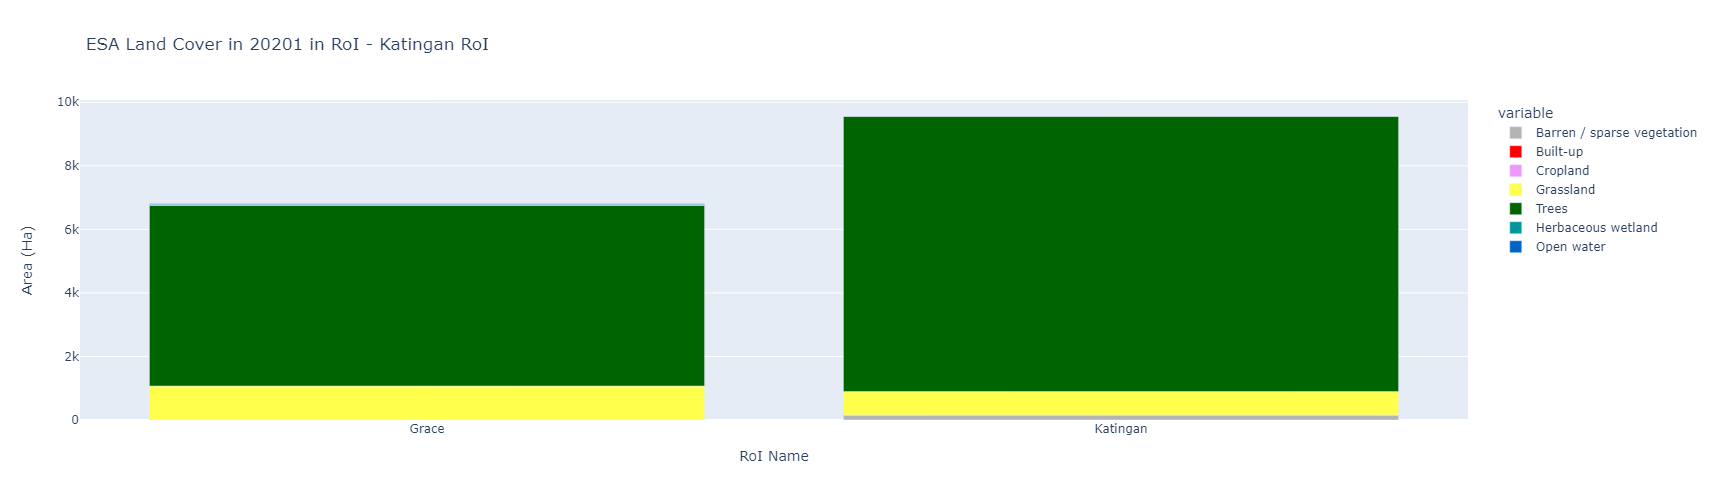

In [26]:
# Degraded Peat area in RoI
fig_ESALC_2021 = px.bar(ESALC_roi_table, x = roi_column_name, y = landcover_list,
                         category_orders={"ESA Land Cover 2021": [ 'Trees','Shrubland','Grassland','Cropland','Built-up',
                                                                  'Barren / sparse vegetation','Snow and ice','Open water',
                                                                  'Herbaceous wetland','Mangroves','Moss and lichen'
                                                                 ]},
                         color_discrete_sequence = lc_colorlist,
                         width=1400, height=500, 
                         labels = {roi_column_name: "RoI Name", "value": "Area (Ha)"},
                         title ="ESA Land Cover in 20201 in RoI - " + projectname)
fig_ESALC_2021

### ESA Land Cover Map in 2021

In [27]:
root2 = Tk() # pointing root to Tk() to use it as Tk() in program.
root2.withdraw() # Hides small tkinter window.
root2.attributes('-topmost', True) # Opened windows will be active. above all windows despite of selection.
raster_directory = filedialog.askdirectory(title = "Specify Raster Folder Directory")

In [28]:
# Set 0 as null in rasterio
with rasterio.open(os.path.join(raster_directory, projectname + '_ESALandCover_2021_roi.tif').replace(os.sep, '/'), "r+") as rasterdata:
    rasterdata.nodata = 0
    profile = rasterdata.profile

In [29]:
# Import Raster Data
esalc_2021_raster = rasterio.open(os.path.join(raster_directory, projectname + '_ESALandCover_2021_roi.tif').replace(os.sep, '/'))

In [30]:
# get unique raster value for legend
raster_array = esalc_2021_raster.read(1)
unique_value = np.unique(raster_array).tolist()

In [31]:
raster_class_label = []
raster_class_color = []
for x in unique_value:
    if x == 10:
        raster_class_color.append("#006400")
        raster_class_label.append("Trees")
    elif x == 20:
        raster_class_color.append("#ffbb22")
        raster_class_label.append("Shrubland")
    elif x == 30:
        raster_class_color.append("#ffff4c")
        raster_class_label.append("Grassland")  
    elif x == 40:
        raster_class_color.append("#f096ff")
        raster_class_label.append("Cropland")  
    elif x == 50:
        raster_class_color.append("#fa0000")
        raster_class_label.append("Built-up")  
    elif x == 60:
        raster_class_color.append("#b4b4b4")
        raster_class_label.append("Barren / sparse vegetation")  
    elif x == 70:
        raster_class_color.append("#f0f0f0")
        raster_class_label.append("Snow and ice")  
    elif x == 80:
        raster_class_color.append("#0064c8")
        raster_class_label.append("Open water")  
    elif x == 90:
        raster_class_color.append("#0096a0")
        raster_class_label.append("Herbaceous wetland")  
    elif x == 95:
        raster_class_color.append("#00cf75")
        raster_class_label.append("Mangroves")  
    elif x == 100:
        raster_class_color.append("#fae6a0")
        raster_class_label.append("Moss and lichen")
    else:
        raster_class_color.append("#000000")
        raster_class_label.append("Unknown")

In [32]:
legend_df = pd.DataFrame(
    {'lc_label': raster_class_label,
     'lc_color': raster_class_color
    })

In [33]:
handles_list = []
for i in range(0,len(legend_df)):
    handles_list.append(mpatches.Patch(color=legend_df.iloc[i]['lc_color'], label=legend_df.iloc[i]['lc_label']))    

In [34]:
# raster color visualisation
colors_esalc = ['#006400','#ffbb22','#ffff4c','#f096ff','#fa0000','#b4b4b4','#f0f0f0','#0064c8','#0096a0','#00cf75','#fae6a0']
cmap_esalc = ListedColormap(colors_esalc)
norm_esalc = colors.BoundaryNorm([0, 10.5, 20.5, 30.5, 40.5, 50.5, 60.5, 70.5, 80.5, 90.5, 95.5, 100.5], 12)

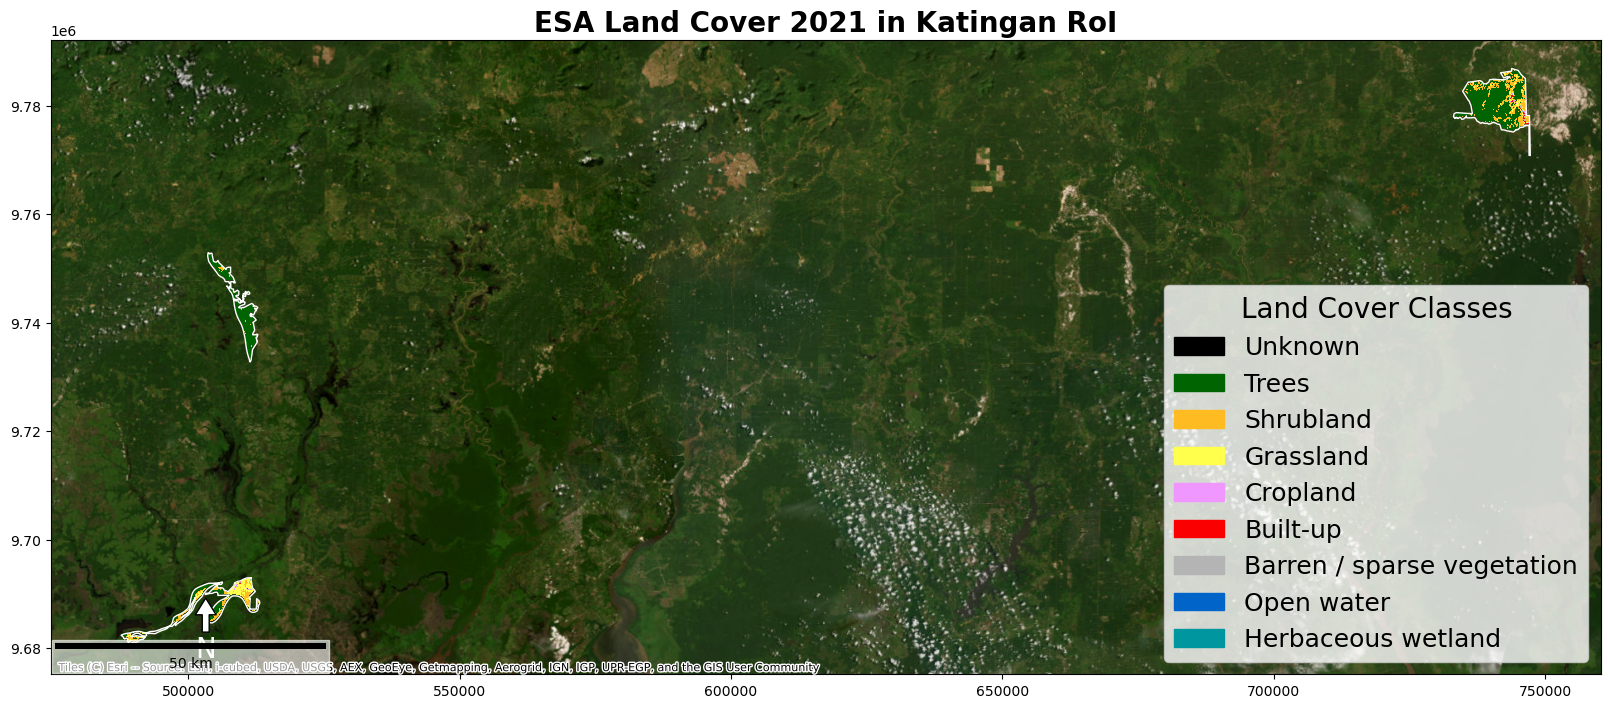

In [36]:
#import overlay raster
fig_esa, ax_esa = plt.subplots(figsize=(20,20))

x, y, arrow_length = 0.1, 0.12, 0.08
ax_esa.annotate('N', color='white', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='white', width=5, headwidth=15),
                     ha='center', va='center', fontsize=20,
                     xycoords=ax_esa.transAxes)

legend = ax_esa.legend(handles=handles_list,facecolor="white", prop={'size': 18}, loc='lower right', title = "Land Cover Classes")
plt.setp(legend.get_title(),fontsize='20')

ax_esa.set_title('ESA Land Cover 2021 in ' + projectname, fontsize=20, fontweight="bold")

ax_esa.add_artist(ScaleBar(1, box_alpha=0.6, location = 'lower left'))
ax_esa = roi_proj.plot(figsize=(20, 20), color = None, edgecolor = 'white', facecolor="none", ax = ax_esa)
ax_esa = ctx.add_basemap(source=ctx.providers.Esri.WorldImagery, crs=roi_proj.crs.to_string(), ax = ax_esa )
ax_esa = rasterio.plot.show(esalc_2021_raster, ax=ax_esa, cmap=cmap_esalc, norm= norm_esalc)

## Export Data

In [37]:
# export csv data
ESALC_roi_table.to_csv(os.path.join(out_dir, projectname + '_ESALandCover_2021_roi.csv'))

# export charts
fig_ESALC_2021.write_image(os.path.join(out_dir, projectname + '_ESALandCover_2021_Graph.png'))

# export map
fig_esa.savefig(os.path.join(out_dir, projectname + '_ESALandCover_2021_Map.png'), facecolor='white',  bbox_inches='tight')